In [1]:
import pandas as pd
import numpy as np

import plotly.graph_objects as go

import dash
from dash import dcc as doc
from dash.dependencies import Input, Output
from dash import html
import dash_daq as daq

from scipy import optimize
from scipy import integrate

# Data Visualization with Dashboard

## Load Dataset

In [2]:
df_covid = pd.read_csv("../data/raw/covid_full_data.csv", sep=";")
countries = df_covid['location'].unique()

## Define SIR functions

In [3]:
N0=0
S0=0
I0=0
R0=0
t=0
def SIR_model_t(SIR,t,beta,gamma):
    global N0
    ''' Simple SIR model
        S: susceptible population
        t: time step, mandatory for integral.odeint
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return dS_dt,dI_dt,dR_dt

In [4]:
def fit_odeint(x, beta, gamma):
    '''
    helper function for the integration
    '''
    global S0, I0, R0, t
    return integrate.odeint(SIR_model_t, (S0, I0, R0), t, args=(beta, gamma))[:,1] # we only would like to get dI
    # return integrate.odeint(SIR_model_t, (S0, I0, R0), t, args=(beta, gamma))[:,2] # we only would like to get S to get the total cases with N0-S

## Visualization with Plotly

In [5]:
fig_sir = go.Figure()
# # defines the overall layout properties
# fig.update_layout(
#     width=1200,
#     height=1200,
#     xaxis_title='Time',
#     yaxis_title='Confirmed infected people (source: Our World in Data, log-scale)',
# )
# fig.update_yaxes(type='log',range=[1.1,10])

# fig.update_layout(xaxis_rangeslider_visible=True)
# # fig.show(renderer='browser')

In [6]:
app = dash.Dash()
app.layout = html.Div([
    html.H1('Dynamic Covid-19 Dashboard'),
    daq.BooleanSwitch(id='loglin_switch', on=False, label="Logarithmic scale", labelPosition="top"),
    html.Label('Select the countries to display:'),
    doc.Dropdown(
        id = 'country_drop_down',
        options=[{'label': country, 'value': country} for country in countries],
        value=['Germany'],        # which are pre-selected
        multi=True
    ),
    doc.Graph(figure=fig_sir,id='main_window_sir')
])

In [7]:
@app.callback(
    Output('main_window_sir', 'figure'),
    [Input('country_drop_down', 'value'), Input('loglin_switch', 'on')])
def update_figure(countries_to_show, switch_state):
    global N0, S0, I0, R0, t
    traces = []
    for country in countries_to_show:
        total_cases_country = df_covid.total_cases[df_covid.location==country]
        ydata = np.array(total_cases_country.iloc[100:])
        t=np.arange(len(ydata))
        # ensure re-initialization
        N0 = df_covid.population[df_covid.location==country].iloc[35]        # new: use population from dataframe to use correct population size
        # N0 = 20000000 #max susceptible population
        I0=ydata[0]
        S0=N0-I0
        R0=0
        # the resulting curve has to be fitted
        # free parameters are here beta and gamma
        popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)       # popt contains fitted beta and gamma
        print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
        # get the final fitted curve
        fitted = fit_odeint(t, *popt)
        ydata = np.ediff1d(ydata, to_begin=ydata[1]-ydata[0])
        print(N0, I0, S0)
        
        traces.append(dict(x=t,
                             y=ydata,
                             name=f"Infected people {country}",
                             opacity=0.9,
                             line_width=2,
                             marker_size=4,
                             mode='markers'
                          )
                     )
        traces.append(dict(x=t,
                             y=fitted,
                             name=f"SIR-model {country}",
                             line_width=2,
                             marker_size=4,
                             mode='lines'
                          )
                     )
        
    return {
        'data': traces,
        'layout': dict(width=1280,
                        height=720,
                        title="Fit of SIR model for selected countries",
                        xaxis_title='Days',
                        yaxis_title='Population infected',
                        xaxis={'tickangle':-45,
                              'nticks':20,
                              'tickfont':dict(size=14,color='#7f7f7f'),
                              },
                        yaxis={
                            'type': ('log' if switch_state else 'linear'),
                            'range':('[0.1,100]' if switch_state else '[0,100000000]'),
                        })
    }

In [8]:
# take care to press stop button before calling once again, since address will be blocked (server up)
app.run(debug=True, use_reloader=False)

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
Optimal parameters: beta = 0.1969109952219192  and gamma =  0.18366532607582967
83408554.0 164807.0 83243747.0
Optimal parameters: beta = 0.1969109952219192  and gamma =  0.18366532607582967
83408554.0 164807.0 83243747.0
Optimal parameters: beta = 0.1969109952219192  and gamma =  0.18366532607582967
83408554.0 164807.0 83243747.0


In [9]:
country = "Germany"
total_cases_country = df_covid.total_cases[df_covid.location==country]
ydata = np.array(total_cases_country.iloc[100:])
t=np.arange(len(ydata))
N0 = 10000000 #max susceptible population
I0=ydata[0]
S0=N0-I0
R0=0
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)       # popt contains fitted beta and gamma
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
fitted = fit_odeint(t, *popt)

Optimal parameters: beta = 0.002391733915412187  and gamma =  -0.004664458763472929


In [10]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns


sns.set(style="darkgrid")

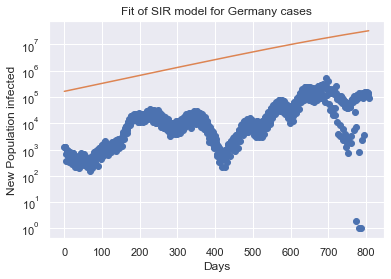

Optimal parameters: beta = 0.002391733915412187  and gamma =  -0.004664458763472929
Basic Reproduction Number R0  -0.512757007124106
This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki


In [11]:
plt.semilogy(t,np.ediff1d(ydata, to_begin=ydata[1]-ydata[0]), 'o')
plt.semilogy(t, fitted)

plt.title("Fit of SIR model for Germany cases")
plt.ylabel("New Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
print("Basic Reproduction Number R0 " , popt[0]/ popt[1])
print("This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki")
